# User behavior analysis and Video Recommendation using K-means Clustering

This project focuses on building a video recommendation system for streaming platforms by analyzing user behavior patterns using K-Means clustering in Python. The goal of this project is to understand user preferences and improve content recommendations, thereby enhancing user engagement.

In [29]:
!pip install scikit-surprise

In [30]:
# setup libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, mean_squared_error

In [31]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/streaming_data.csv')

In [32]:
df.head(5)

,User_ID,Session_ID,Device_ID,Video_ID,Duration_Watched (minutes),Genre,Country,Age,Gender,Subscription_Status,Ratings,Languages,Device_Type,Location,Playback_Quality,Interaction_Events
0,eb4f9229-74df-45f6-baac-cf19241b8b30,cb2142a7-0750-49ed-b8ac-a975fe1ff69a,232,11,90.044525,Sci-Fi,Sudan,56,Female,Premium,3,Spanish,Smartphone,Reedshire,4K,73
1,661d4b59-4328-410a-901c-1e3b4c40c334,3bc0a662-b353-4015-8b0c-55ceb510d13a,549,85,68.973479,Comedy,Cuba,52,Male,Premium,3,Chinese,Desktop,Stevenhaven,SD,22
2,dd3fe9e9-ea82-4891-ab93-8a47c80e3251,bd545b4a-9f54-4e87-b9f8-15ae20b44f22,844,50,42.511343,Comedy,Japan,14,Female,Premium,3,Spanish,Tablet,Vaughntown,HD,41
3,a1b3365b-1d00-4ddf-bc43-02fc9c10c680,0441086d-c59e-478d-a496-5c5b995ecfdb,201,38,53.316660,Documentary,Lao People's Democratic Republic,36,Male,Premium,2,Spanish,Laptop,East Raymondbury,SD,40
4,338d3f91-5f1c-4590-8803-324901826406,0295f01d-7f15-4799-856c-90c688697ef8,700,31,69.437786,Action,Bangladesh,31,Male,Premium,4,German,Laptop,Michaelchester,HD,41


# Data preprocessing

In [33]:
# Check for missing values
df.isnull().sum()

# Fill missing values (you can decide how to handle them, here we use mean or mode)
df['Duration_Watched (minutes)'].fillna(df['Duration_Watched (minutes)'].mean(), inplace=True)
df['Ratings'].fillna(df['Ratings'].mode()[0], inplace=True)

<ipython-input-33-ab59a59c7433>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Duration_Watched (minutes)'].fillna(df['Duration_Watched (minutes)'].mean(), inplace=True)
<ipython-input-33-ab59a59c7433>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing '

In [34]:
# Convert categorical columns to numerical (using one-hot encoding for categorical features)
df = pd.get_dummies(df, columns=['Genre', 'Playback_Quality', 'Subscription_Status', 'Device_Type', 'Languages'], drop_first=True)

# Create a User-Video Interaction Matrix
user_video_matrix = df.pivot_table(index='User_ID', columns='Video_ID', values='Duration_Watched (minutes)', fill_value=0)

# Check the shape of the interaction matrix
user_video_matrix.head()


Video_ID,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
User_ID,,,,,,,,,,,,,,,,,,,,,
00018346-7281-4243-8770-1183e27d91b8,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
00051b4e-afec-4bb9-9b3e-7ada8b879d08,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.940945,0.0,0.0
000be641-412f-443a-9055-44fed4177754,0.0,0.0,0.0,22.190185,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
000d8c31-7308-47bf-b629-74209b7afd24,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
002a1202-e1dd-4f83-8888-45b63b726497,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [35]:
# Normalize the data for clustering (K-Means requires normalized data)
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df[['Duration_Watched (minutes)', 'Ratings', 'Interaction_Events']])

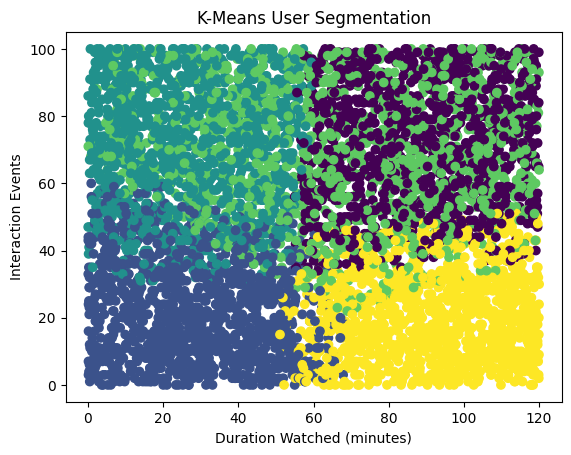

In [36]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df['Cluster'] = kmeans.fit_predict(normalized_data)

# Visualize the clusters
plt.scatter(df['Duration_Watched (minutes)'], df['Interaction_Events'], c=df['Cluster'], cmap='viridis')
plt.title('K-Means User Segmentation')
plt.xlabel('Duration Watched (minutes)')
plt.ylabel('Interaction Events')
plt.show()

# Sequential data preparation for RNN/LSTM model

In [37]:
from sklearn.model_selection import train_test_split as sk_train_test_split

# Sort the data by User_ID and Session_ID for sequential learning
df.sort_values(by=['User_ID', 'Session_ID'], inplace=True)

# Define features and target (e.g., predicting future interaction events)
features = df[['Duration_Watched (minutes)', 'Ratings', 'Interaction_Events']].values
target = df['Interaction_Events'].shift(-1).fillna(0).values  # Next interaction event as target

# Reshape data for LSTM (samples, time steps, features)
X = []
y = []
time_step = 5  # You can adjust this based on your dataset

for i in range(len(features) - time_step):
    X.append(features[i:i+time_step])
    y.append(target[i+time_step])

X = np.array(X)
y = np.array(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = sk_train_test_split(X, y, test_size=0.2, random_state=42)

# Building and Training LSTM Model

In [38]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 2783.7786 - val_loss: 956.8192
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 887.0330 - val_loss: 847.3356
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 846.3709 - val_loss: 847.3274
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 831.4250 - val_loss: 847.5842
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 856.4124 - val_loss: 847.4245
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 846.1046 - val_loss: 847.5276
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 833.0710 - val_loss: 847.7845
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 869.7275 - val_loss: 849.1681
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 841.0562 - val_loss: 847.4491
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 856.7216 - val_loss: 847.8603


# Making predictions and analyzing results

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


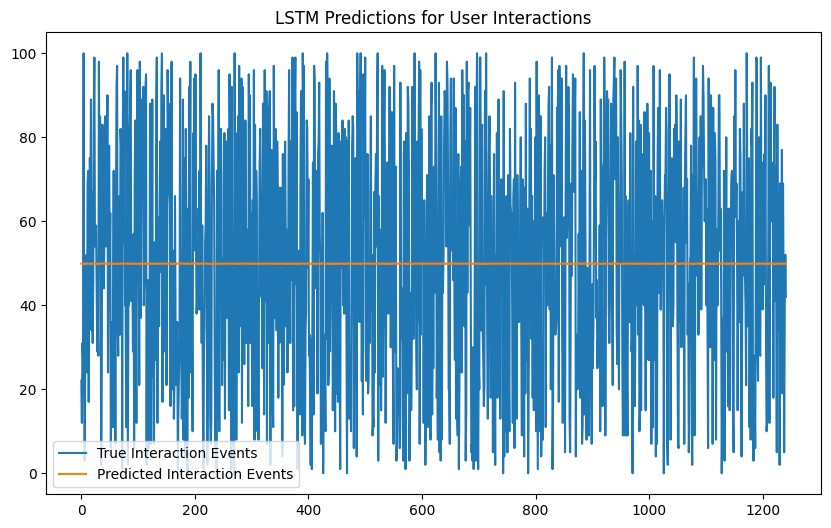

In [39]:
# Predict on the test set
predictions = model.predict(X_test)

# Plot predictions vs true values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Interaction Events')
plt.plot(predictions, label='Predicted Interaction Events')
plt.title('LSTM Predictions for User Interactions')
plt.legend()
plt.show()

# Analysis of user behaviour based on popular genres or duration of content watched

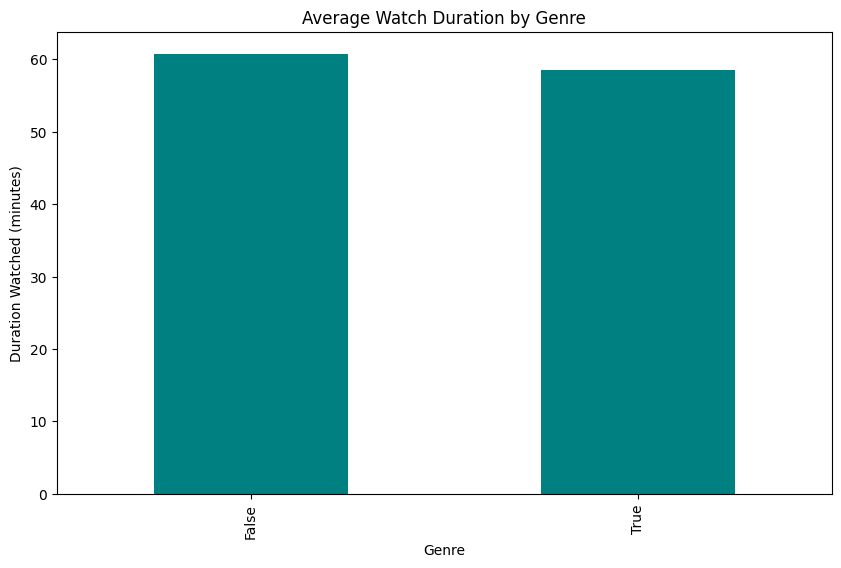

In [40]:
# Analyze the average watch duration per genre
genre_analysis = df.groupby('Genre_Comedy')['Duration_Watched (minutes)'].mean()

# Plot average watch duration by genre
genre_analysis.plot(kind='bar', figsize=(10, 6), color='teal')
plt.title('Average Watch Duration by Genre')
plt.ylabel('Duration Watched (minutes)')
plt.xlabel('Genre')
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


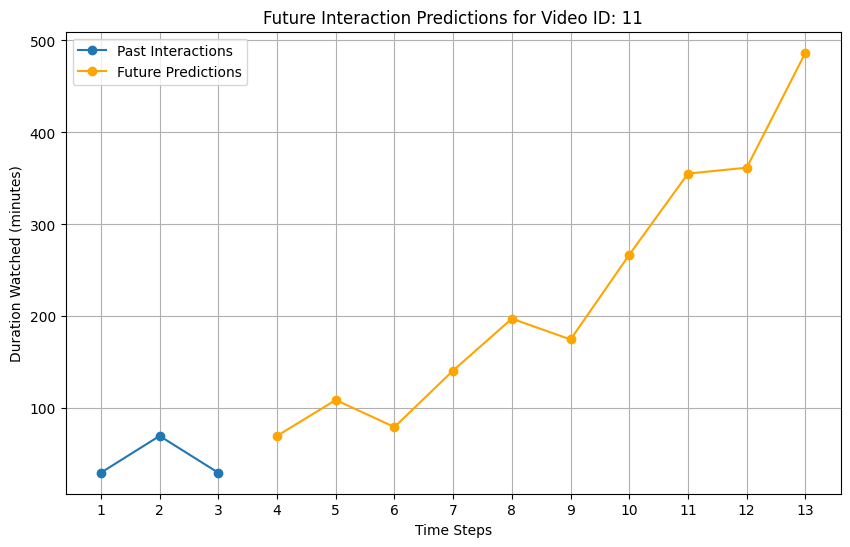

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


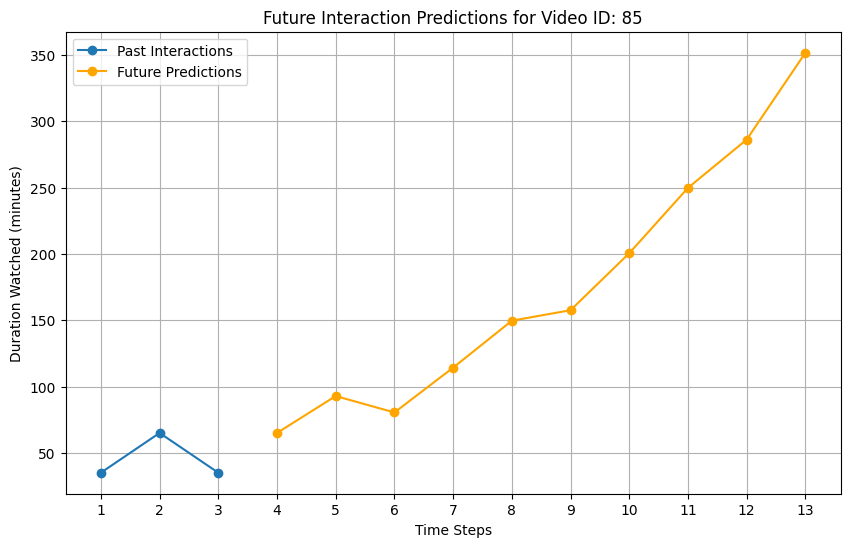

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


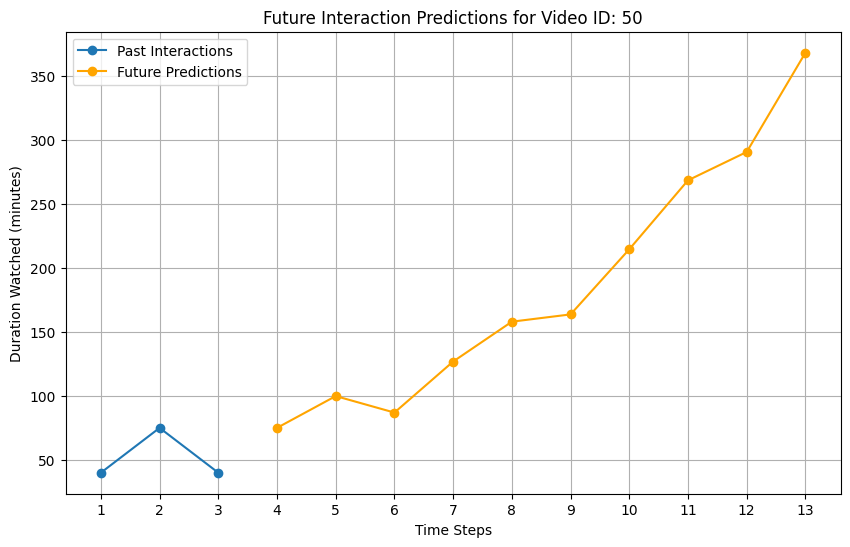

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


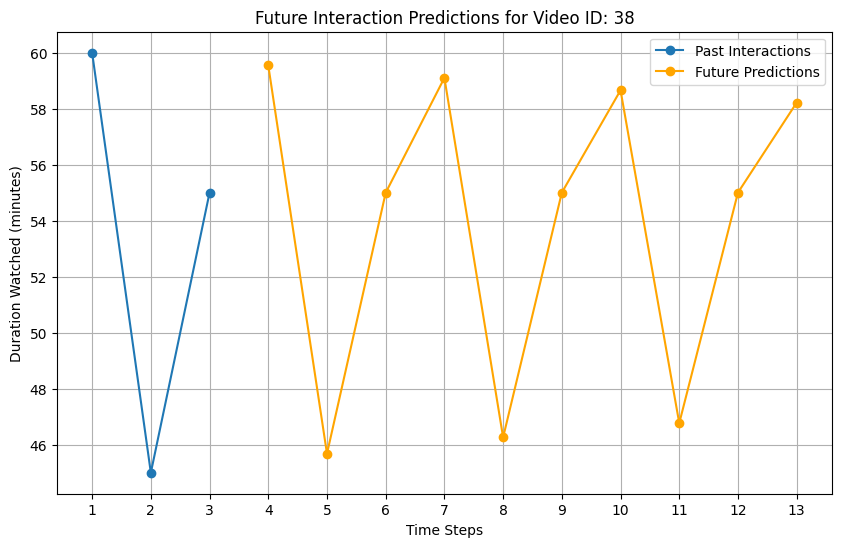

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


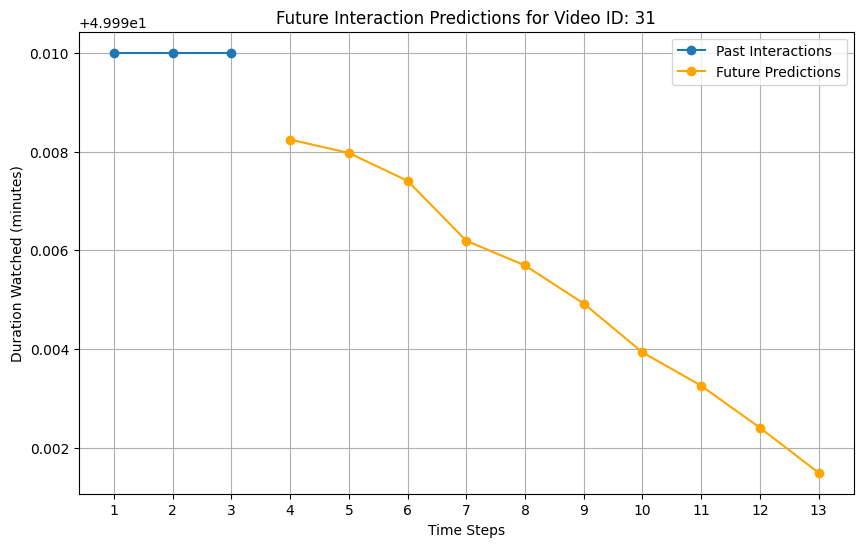

In [41]:
# Replace this with your actual DataFrame containing 'Video_ID' and 'Duration_Watched (minutes)'
video_data = pd.DataFrame({
    'Video_ID': ['11', '85', '50', '38', '31', '38', '38', '85', '11', '50'],
    'Duration_Watched (minutes)': [30, 35, 40, 45, 50, 55, 60, 65, 70, 75]
})

# Set parameters
time_steps = 3  # Number of time steps for input sequence
future_steps = 10  # Number of future steps to predict

# Unique video IDs
video_ids = video_data['Video_ID'].unique()

# Function to create sequences and train the model for each video
def train_and_predict(video_id):
    # Filter data for the specific video
    video_interactions = video_data[video_data['Video_ID'] == video_id]

    # Ensure there are enough data points by duplicating if necessary
    while len(video_interactions) < time_steps + 1:
        video_interactions = pd.concat([video_interactions, video_interactions], ignore_index=True)

    # Create sequences from the video's interaction data
    sequences = []
    target = []

    # Generate sequences for model training
    for i in range(len(video_interactions) - time_steps):
        sequences.append(video_interactions['Duration_Watched (minutes)'].iloc[i:i + time_steps].values)
        target.append(video_interactions['Duration_Watched (minutes)'].iloc[i + time_steps])

    sequences = np.array(sequences)
    target = np.array(target)

    # Reshape for LSTM input
    X = sequences.reshape(sequences.shape[0], sequences.shape[1], 1)

    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(time_steps, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Train the model on the video's data
    model.fit(X, target, epochs=200, verbose=0)

    # Use the last available sequence for future predictions
    last_sequence = X[-1].reshape(1, time_steps, 1)

    # Predict future interactions
    future_predictions = []

    for _ in range(future_steps):
        prediction = model.predict(last_sequence)
        future_predictions.append(prediction[0, 0])

        # Update the last sequence with the new prediction
        prediction_reshaped = prediction.reshape(1, 1, 1)  # Reshape to (1, 1, 1) for appending
        last_sequence = np.append(last_sequence[:, 1:, :], prediction_reshaped, axis=1)

    return future_predictions, sequences[-1]  # Return the future predictions and the last sequence for plotting

# Plot future predictions for each video
for video_id in video_ids:
    future_predictions, last_sequence = train_and_predict(video_id)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, time_steps + 1), last_sequence, label='Past Interactions', marker='o')
    plt.plot(range(time_steps + 1, time_steps + future_steps + 1), future_predictions,
             label='Future Predictions', marker='o', color='orange')
    plt.title(f'Future Interaction Predictions for Video ID: {video_id}')
    plt.xlabel('Time Steps')
    plt.ylabel('Duration Watched (minutes)')
    plt.xticks(range(1, time_steps + future_steps + 1))
    plt.legend()
    plt.grid()
    plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


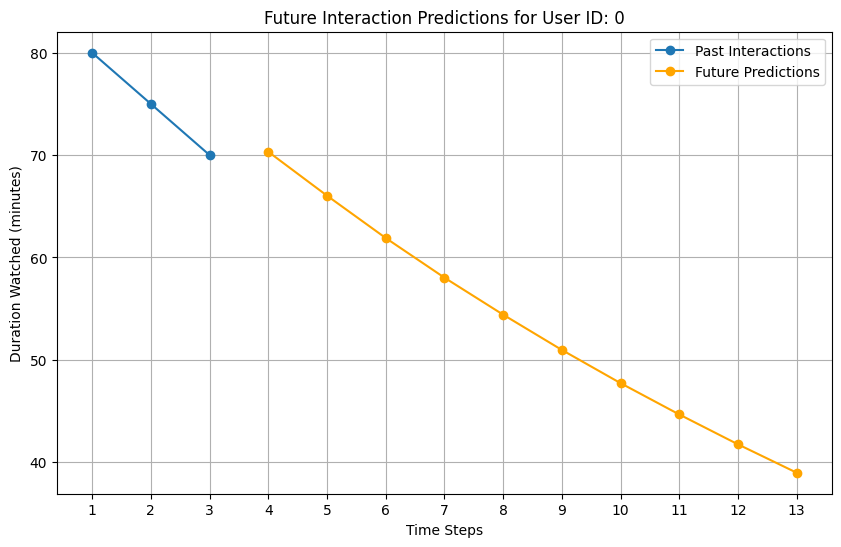

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


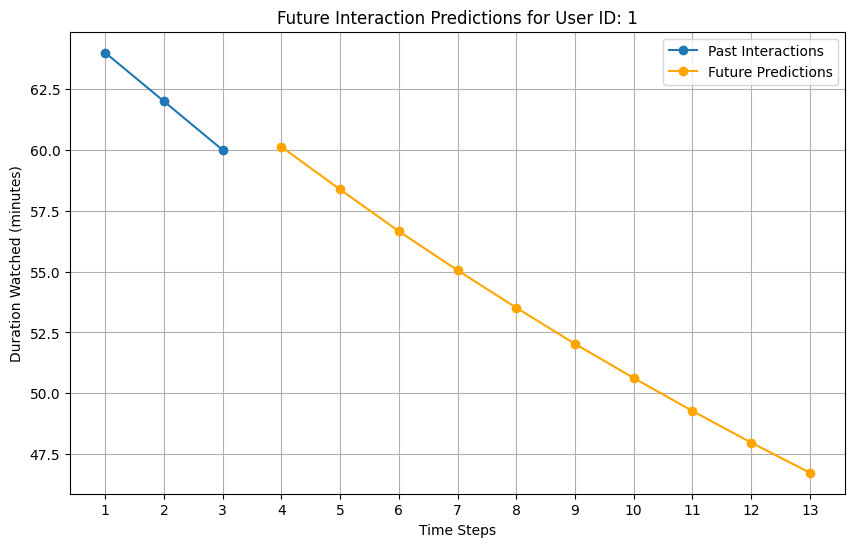

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


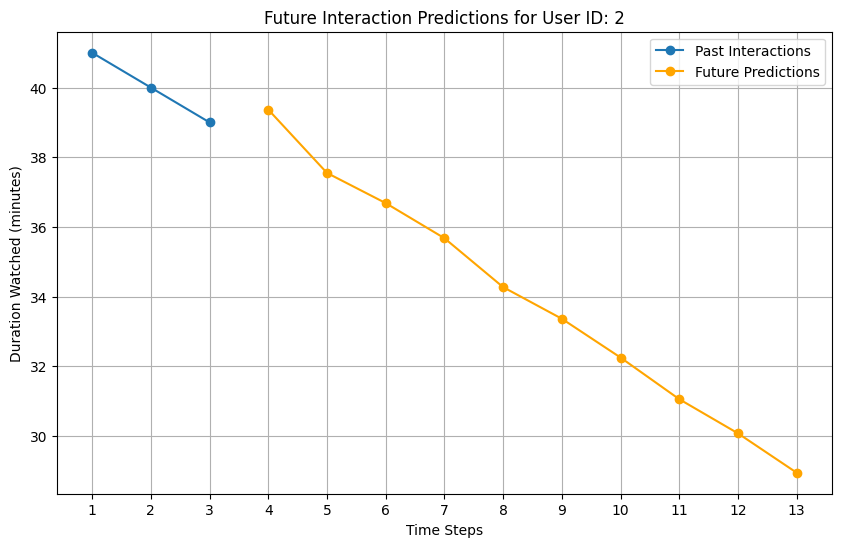

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


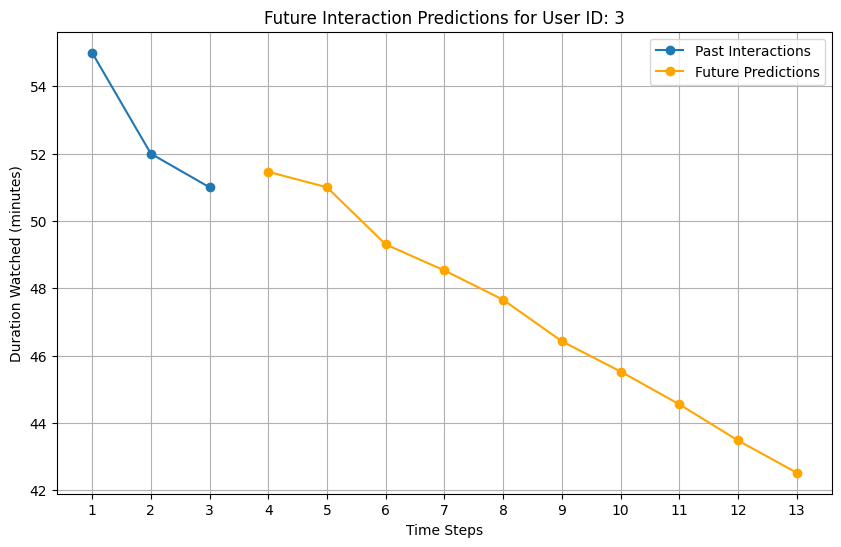

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


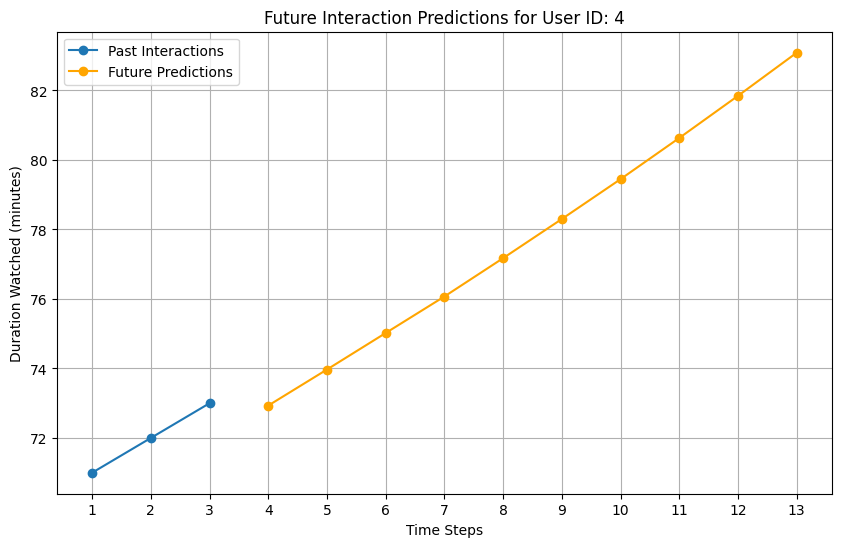

In [42]:
# Simulated DataFrame setup with multiple users
user_data = pd.DataFrame({
    'User_ID': ['eb4f9229-74df-45f6-baac-cf19241b8b30'] * 5 +
               ['cb2142a7-0750-49ed-b8ac-a975fe1ff69a'] * 5 +
               ['661d4b59-4328-410a-901c-1e3b4c40c334'] * 5 +
               ['dd3fe9e9-ea82-4891-ab93-8a47c80e3251'] * 5 +
               ['a1b3365b-1d00-4ddf-bc43-02fc9c10c680'] * 5,
    'Video_ID': ['11', '11', '11', '11', '11',
                 '85', '85', '85', '85', '85',
                 '50', '50', '50', '50', '50',
                 '38', '38', '38', '38', '38',
                 '31', '31', '31', '31', '31'],
    'Duration_Watched (minutes)': [90.0, 85.0, 80.0, 75.0, 70.0,
                                   68.0, 66.0, 64.0, 62.0, 60.0,
                                   42.5, 43.5, 41.0, 40.0, 39.0,
                                   53.3, 54.0, 55.0, 52.0, 51.0,
                                   69.4, 70.0, 71.0, 72.0, 73.0]
})

# Set parameters
time_steps = 3  # Number of time steps for input sequence
future_steps = 10  # Number of future steps to predict

# Create a mapping from User_ID to integer
user_id_mapping = {user_id: idx for idx, user_id in enumerate(user_data['User_ID'].unique())}
user_data['User_ID'] = user_data['User_ID'].map(user_id_mapping)

# Unique user IDs as integers
user_ids = user_data['User_ID'].unique()

# Function to create sequences and train the model for each user
def train_and_predict(user_id):
    # Filter data for the specific user
    user_interactions = user_data[user_data['User_ID'] == user_id]

    # Check if there are enough data points
    if len(user_interactions) < time_steps + 1:
        print(f"Not enough data points for User ID {user_id}. Skipping this user.")
        return None

    # Create sequences from the user's interaction data
    sequences = []
    target = []

    # Generate sequences for model training
    for i in range(len(user_interactions) - time_steps):
        sequences.append(user_interactions['Duration_Watched (minutes)'].iloc[i:i + time_steps].values)
        target.append(user_interactions['Duration_Watched (minutes)'].iloc[i + time_steps])

    sequences = np.array(sequences)
    target = np.array(target)

    # Check if sequences are empty before reshaping
    if sequences.size == 0:
        raise ValueError(f"No sequences were created for User ID {user_id}. Please check the user data.")

    # Reshape for LSTM input
    X = sequences.reshape(sequences.shape[0], sequences.shape[1], 1)

    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(time_steps, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Train the model on the user's data
    model.fit(X, target, epochs=200, verbose=0)

    # Use the last available sequence for future predictions
    last_sequence = X[-1].reshape(1, time_steps, 1)

    # Predict future interactions
    future_predictions = []

    for _ in range(future_steps):
        prediction = model.predict(last_sequence)
        future_predictions.append(prediction[0, 0])

        # Update the last sequence with the new prediction
        prediction_reshaped = prediction.reshape(1, 1, 1)  # Reshape to (1, 1, 1) for appending
        last_sequence = np.append(last_sequence[:, 1:, :], prediction_reshaped, axis=1)

    return future_predictions

# Plot future predictions for each user
for user_id in user_ids:
    future_predictions = train_and_predict(user_id)

    if future_predictions is None:
        continue  # Skip plotting if there are no predictions

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, time_steps + 1),
             user_data[user_data['User_ID'] == user_id]['Duration_Watched (minutes)'].values[-time_steps:],
             label='Past Interactions', marker='o')
    plt.plot(range(time_steps + 1, time_steps + future_steps + 1), future_predictions,
             label='Future Predictions', marker='o', color='orange')
    plt.title(f'Future Interaction Predictions for User ID: {user_id}')
    plt.xlabel('Time Steps')
    plt.ylabel('Duration Watched (minutes)')
    plt.xticks(range(1, time_steps + future_steps + 1))
    plt.legend()
    plt.grid()
    plt.show()

In [43]:
# Load the dataset into Surprise's format
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['User_ID', 'Video_ID', 'Ratings']], reader)

# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2)

# Use SVD (Singular Value Decomposition) for collaborative filtering
algo = SVD()

# Train the algorithm on the trainset
algo.fit(trainset)

# Test the algorithm on the testset
predictions = algo.test(testset)

# Compute and print RMSE (Root Mean Squared Error)
accuracy.rmse(predictions)

# Function to get video recommendations for a specific user
def get_recommendations(user_id, n=5):
    # Get a list of all video IDs
    video_ids = df['Video_ID'].unique()

    # Predict the ratings for all videos the user hasn't watched
    predictions = [algo.predict(user_id, vid) for vid in video_ids]

    # Sort the predictions by the estimated rating
    recommendations = sorted(predictions, key=lambda x: x.est, reverse=True)

    # Get the top N video recommendations
    top_recommendations = recommendations[:n]

    # Return the Video IDs of the top recommendations
    return [(rec.iid, rec.est) for rec in top_recommendations]

# Get unique user IDs from the dataset
user_ids = df['User_ID'].unique()

# Print recommendations for the first 20 user IDs
for user_id in user_ids[:10]:  # Only take the first 20 user IDs
    recommendations = get_recommendations(user_id, n=5)
    print(f'\nRecommendations for User ID:')

    # Print each recommendation separately in the desired format
    for i, (video_id, est_rating) in enumerate(recommendations, start=1):
        print(f' User ID: {user_id}: Recommendation {i}: Video ID: {video_id}, Estimated Rating: {est_rating}')

RMSE: 1.4055

Recommendations for User ID:
 User ID: 00018346-7281-4243-8770-1183e27d91b8: Recommendation 1: Video ID: 51, Estimated Rating: 3.646413420872279
 User ID: 00018346-7281-4243-8770-1183e27d91b8: Recommendation 2: Video ID: 92, Estimated Rating: 3.495621251722692
 User ID: 00018346-7281-4243-8770-1183e27d91b8: Recommendation 3: Video ID: 78, Estimated Rating: 3.3940980824634037
 User ID: 00018346-7281-4243-8770-1183e27d91b8: Recommendation 4: Video ID: 95, Estimated Rating: 3.3724436263520436
 User ID: 00018346-7281-4243-8770-1183e27d91b8: Recommendation 5: Video ID: 23, Estimated Rating: 3.3093770183309505

Recommendations for User ID:
 User ID: 00051b4e-afec-4bb9-9b3e-7ada8b879d08: Recommendation 1: Video ID: 98, Estimated Rating: 3.829309077312196
 User ID: 00051b4e-afec-4bb9-9b3e-7ada8b879d08: Recommendation 2: Video ID: 78, Estimated Rating: 3.789411001321118
 User ID: 00051b4e-afec-4bb9-9b3e-7ada8b879d08: Recommendation 3: Video ID: 63, Estimated Rating: 3.756569064478

In [44]:
# Load the dataset into Surprise's format
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['User_ID', 'Video_ID', 'Ratings']], reader)

# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2)

# Use SVD (Singular Value Decomposition) for collaborative filtering


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
LSTM RMSE: 31.99350459846187


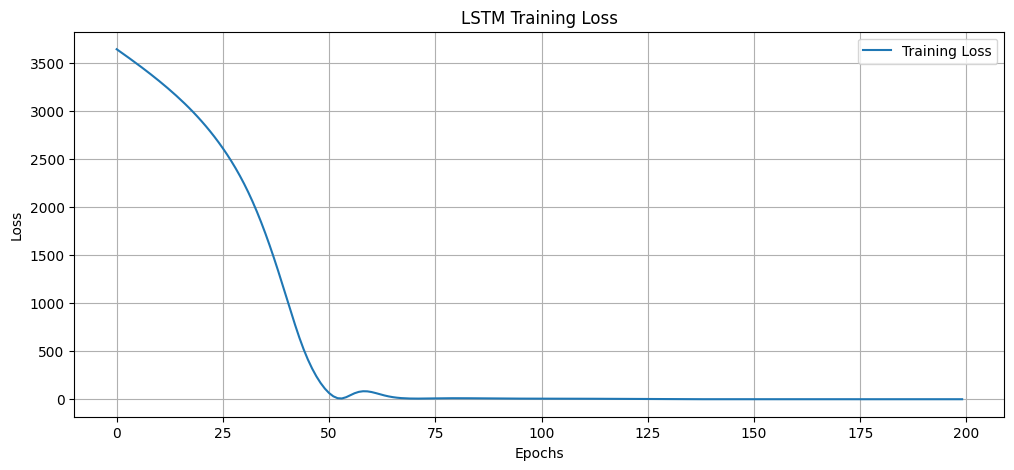

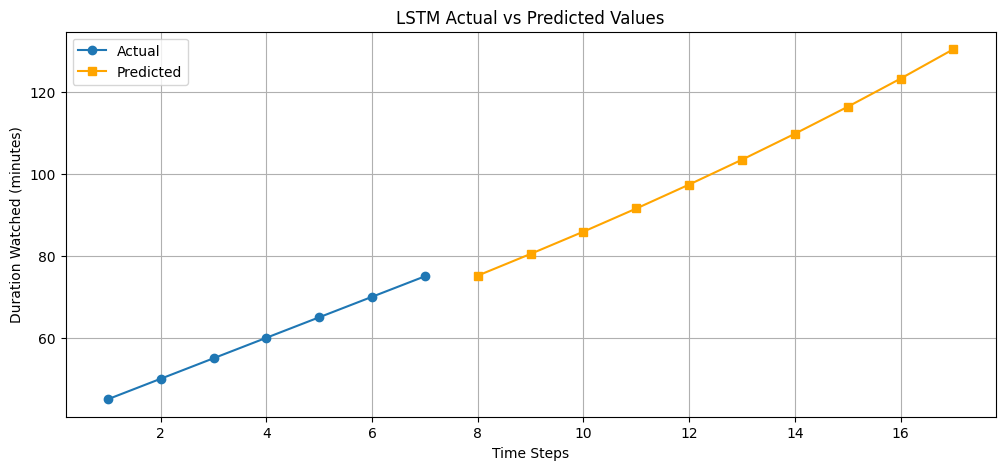

Silhouette Score for K-Means: 0.32329533476654204
Inertia for K-Means: 8.851515151515152


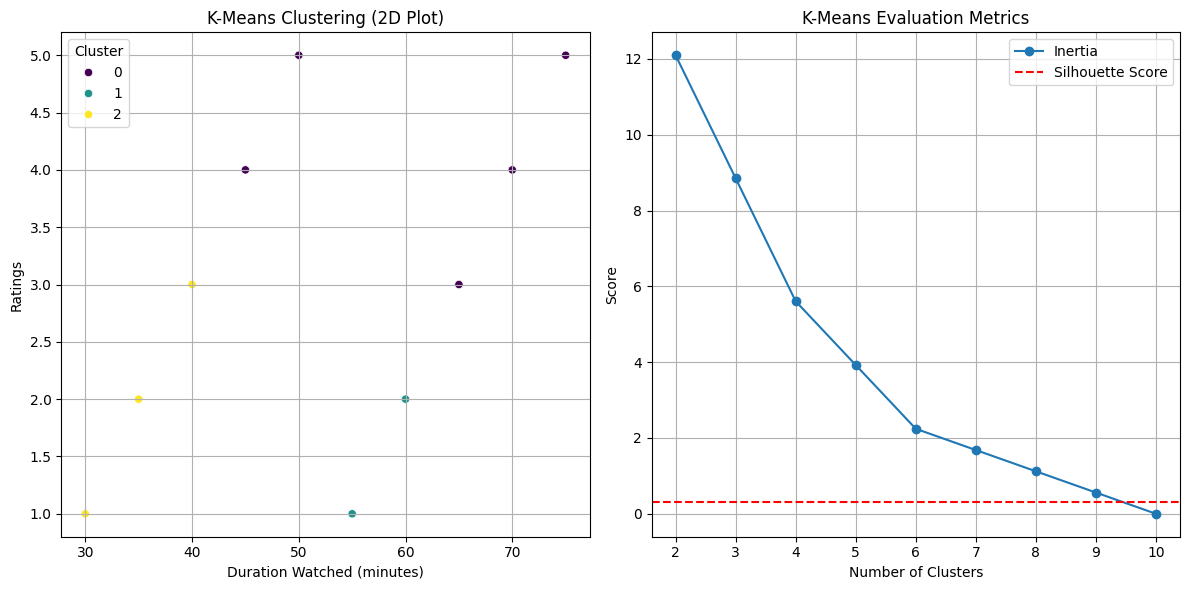

In [45]:
import seaborn as sns
# Sample DataFrame for LSTM (replace this with your actual DataFrame)
# Here, I'm creating a sample DataFrame
video_data = pd.DataFrame({
    'Duration_Watched (minutes)': [30, 35, 40, 45, 50, 55, 60, 65, 70, 75]
})

# LSTM Parameters
time_steps = 3
future_steps = 10

# Prepare data for LSTM
def prepare_lstm_data(data, time_steps):
    sequences = []
    target = []
    for i in range(len(data) - time_steps):
        sequences.append(data.iloc[i:i + time_steps].values)
        target.append(data.iloc[i + time_steps])
    return np.array(sequences), np.array(target)

sequences, target = prepare_lstm_data(video_data['Duration_Watched (minutes)'], time_steps)
X = sequences.reshape(sequences.shape[0], sequences.shape[1], 1)

# Define and train LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
history = model.fit(X, target, epochs=200, verbose=0)

# Predict future values using the trained model
last_sequence = X[-1].reshape(1, time_steps, 1)
future_predictions = []

for _ in range(future_steps):
    prediction = model.predict(last_sequence)
    future_predictions.append(prediction[0, 0])
    prediction_reshaped = prediction.reshape(1, 1, 1)
    last_sequence = np.append(last_sequence[:, 1:, :], prediction_reshaped, axis=1)

# Calculate RMSE for LSTM
rmse = np.sqrt(mean_squared_error(target[-future_steps:], future_predictions[:len(target[-future_steps:])]))
print(f'LSTM RMSE: {rmse}')

# Plot LSTM training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('LSTM Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 5))
plt.plot(range(1, len(target) + 1), target, label='Actual', marker='o')
plt.plot(range(len(target) + 1, len(target) + future_steps + 1), future_predictions, label='Predicted', marker='s', color='orange')
plt.title('LSTM Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Duration Watched (minutes)')
plt.legend()
plt.grid()
plt.show()

# Now, let's evaluate K-Means clustering
# Sample DataFrame for K-Means (replace this with your actual DataFrame)
df = pd.DataFrame({
    'Duration_Watched (minutes)': [30, 35, 40, 45, 50, 55, 60, 65, 70, 75],
    'Ratings': [1, 2, 3, 4, 5, 1, 2, 3, 4, 5],
    'Interaction_Events': [5, 10, 15, 20, 25, 5, 10, 15, 20, 25]
})

# Normalize data for K-Means
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df[['Duration_Watched (minutes)', 'Ratings', 'Interaction_Events']])

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(normalized_data)

# Calculate silhouette score and inertia
silhouette_avg = silhouette_score(normalized_data, df['Cluster'])
inertia = kmeans.inertia_

print(f'Silhouette Score for K-Means: {silhouette_avg}')
print(f'Inertia for K-Means: {inertia}')

# Plot K-Means clustering results
plt.figure(figsize=(12, 6))

# 2D plot of clusters using the first two features
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='Duration_Watched (minutes)', y='Ratings', hue='Cluster', palette='viridis')
plt.title('K-Means Clustering (2D Plot)')
plt.xlabel('Duration Watched (minutes)')
plt.ylabel('Ratings')
plt.legend(title='Cluster')
plt.grid()

# Elbow method and silhouette score plot
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), [KMeans(n_clusters=n, random_state=42).fit(normalized_data).inertia_ for n in range(2, 11)], marker='o', label='Inertia')
plt.axhline(y=silhouette_avg, color='red', linestyle='--', label='Silhouette Score')
plt.title('K-Means Evaluation Metrics')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()